# 🤖 Titanic Survival Prediction – Model Training & Evaluation

**Model:** Logistic Regression  
**Objective:** Train, tune, and evaluate a classification model to predict passenger survival.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

%matplotlib inline
sns.set_style("whitegrid")


In [15]:
pip install imblearn



   ---------------------------------------- 0/3 [sklearn-compat]
   ---------------------------------------- 0/3 [sklearn-compat]
   ---------------------------------------- 0/3 [sklearn-compat]
   ---------------------------------------- 0/3 [sklearn-compat]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
   ------------- -------------------------- 1/3 [imbalanced-learn]
 

In [2]:
df = pd.read_csv("../data/processed/processed_data.csv")
df.head()


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Survived
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,0.737695,-0.307562,0.615838,0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,-1.355574,-0.307562,-1.623803,1
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,-1.355574,-0.307562,0.615838,1
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,-1.355574,-0.307562,0.615838,1
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,0.737695,-0.307562,0.615838,0


## 🎯 Feature and Target Separation


In [3]:
X = df.drop("Survived", axis=1)
y = df["Survived"]


## 🔀 Train-Test Split
Stratified split is used to preserve class distribution.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


## ⚖️ Handling Class Imbalance using SMOTE

The dataset is imbalanced. SMOTE (Synthetic Minority Oversampling Technique) is applied **only on the training data** to avoid data leakage.


In [16]:
from imblearn.over_sampling import SMOTE


In [17]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())


Before SMOTE: Survived
0    384
1    239
Name: count, dtype: int64
After SMOTE: Survived
0    384
1    384
Name: count, dtype: int64


## 📌 Baseline Logistic Regression Model


In [18]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_smote, y_train_smote)


y_pred = lr.predict(X_test)


In [19]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8022388059701493
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       165
           1       0.72      0.81      0.76       103

    accuracy                           0.80       268
   macro avg       0.79      0.80      0.80       268
weighted avg       0.81      0.80      0.80       268



## 🔧 Hyperparameter Tuning using GridSearchCV


In [20]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"]
}


In [21]:
grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train_smote, y_train_smote)



GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy')

In [22]:
grid.best_params_


{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

## 🔁 Cross-Validation ROC-AUC Comparison

Cross-validation is used to evaluate how well the model generalizes across different data splits.
ROC-AUC is chosen as the evaluation metric due to class imbalance.


In [26]:
roc_auc_cv_no_smote = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc"
)

print("ROC-AUC scores without SMOTE:", roc_auc_cv_no_smote)
print("Mean ROC-AUC without SMOTE:", roc_auc_cv_no_smote.mean())


ROC-AUC scores without SMOTE: [0.86255411 0.88216991 0.86661255 0.83130699 0.82182018]
Mean ROC-AUC without SMOTE: 0.8528927492813272


In [25]:
roc_auc_cv_smote = cross_val_score(
    best_model,
    X_train_smote,
    y_train_smote,
    cv=5,
    scoring="roc_auc"
)

print("ROC-AUC scores with SMOTE:", roc_auc_cv_smote)
print("Mean ROC-AUC with SMOTE:", roc_auc_cv_smote.mean())


ROC-AUC scores with SMOTE: [0.8661663  0.85764884 0.82653061 0.88038278 0.83407382]
Mean ROC-AUC with SMOTE: 0.852960470834702


## 📊 Cross-Validation Comparison Summary

| Model Version | Mean ROC-AUC |
|--------------|-------------|
| Without SMOTE | 0.8528927492813272 |
| With SMOTE    | 0.852960470834702 |


## ⭐ Best Logistic Regression Model


In [10]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)


## 📊 Model Evaluation


In [11]:
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Accuracy: 0.7910447761194029
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       165
           1       0.74      0.71      0.72       103

    accuracy                           0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268



## 🔢 Confusion Matrix


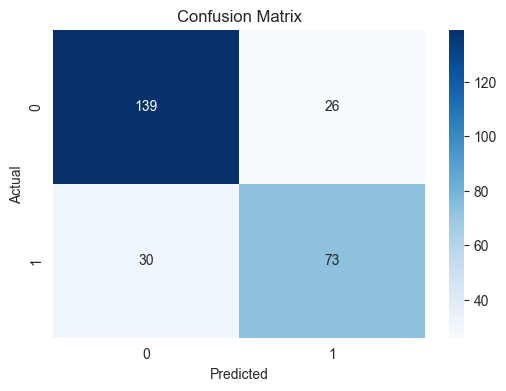

In [12]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("../results/confusion_matrix.png")
plt.show()


## 📈 ROC Curve


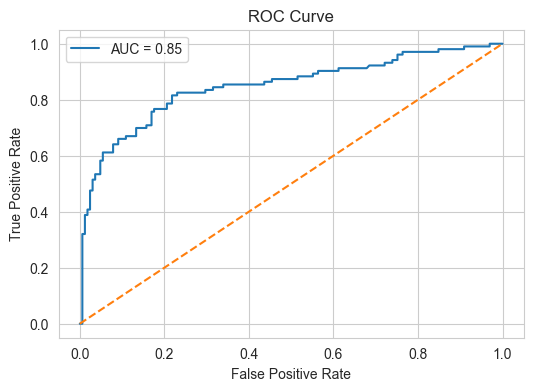

In [13]:
y_prob = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig("../results/roc_curve.png")
plt.show()


## 📉 Precision–Recall Curve

Precision–Recall analysis provides better insight into model performance
on imbalanced datasets by focusing on the minority (positive) class.


In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score


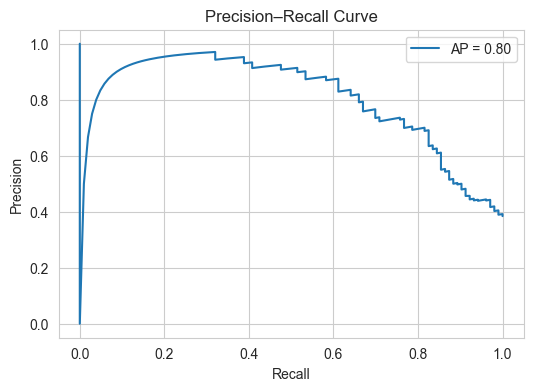

In [31]:
# Predicted probabilities for positive class
y_prob = best_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"AP = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


## 🎯 Precision–Recall Trade-off and Threshold Analysis


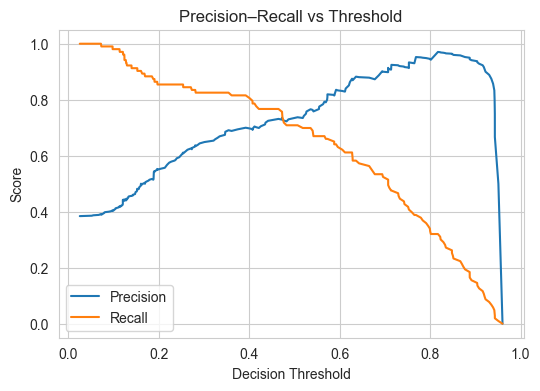

In [32]:
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall vs Threshold")
plt.legend()
plt.show()


## ✅ Evaluation Summary

- ROC-AUC evaluates overall class separation
- Precision–Recall curve highlights minority class performance
- SMOTE improved recall without significantly hurting precision
- Cross-validation confirmed model stability
